# Set-up

Note-to-self:

- 有考虑把`pointplot`作图代码打包成一个函数

In [136]:
# check current path
import os
print(os.getcwd())

'''
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive/')
path_gdrive = '/content/drive/Shareddrives/Enova/2023/Project_decription'
os.chdir(path_gdrive)
print(os.getcwd())
'''

/Users/anthony/Desktop/Enova/data


"\n# Load the Drive helper and mount\nfrom google.colab import drive\n# This will prompt for authorization.\ndrive.mount('/content/drive/')\npath_gdrive = '/content/drive/Shareddrives/Enova/2023/Project_decription'\nos.chdir(path_gdrive)\nprint(os.getcwd())\n"

In [137]:
path_gdrive = '/Users/anthony/Desktop/Enova/data'
os.chdir(path_gdrive)
print(os.getcwd())

/Users/anthony/Desktop/Enova/data


In [138]:
import numpy as np
import pandas as pd
from scipy import stats
import math
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
from matplotlib.colors import ListedColormap

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split


# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

# Read data and check basic info

In [139]:
'''
val_data = pd.read_csv('data_smackdown_2023_validation.csv')
print(val_data.shape)
val_data.info()
'''

"\nval_data = pd.read_csv('data_smackdown_2023_validation.csv')\nprint(val_data.shape)\nval_data.info()\n"

In [140]:
train_data_raw = pd.read_csv('data_smackdown_2023_training.csv')
print(train_data_raw.shape)
train_data_raw.info()

(10001, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        10001 non-null  int64  
 1   residence_type             10001 non-null  object 
 2   address                    10001 non-null  object 
 3   education_level            10001 non-null  object 
 4   job_type                   9054 non-null   object 
 5   number_years_at_job        10001 non-null  int64  
 6   marital_status             10001 non-null  int64  
 7   num_tickets_purchased      10001 non-null  float64
 8   last_ticket_purchase_year  5867 non-null   float64
 9   other_tickets_purchased    8192 non-null   object 
 10  gym_membership_ind         10001 non-null  int64  
 11  prior_year_spend           7164 non-null   float64
 12  prior_year_spend_external  8053 non-null   float64
 13  primary_credit_card        8053 no

In [141]:
df = train_data_raw.copy()

## Check missing values
- check the ratio of missing values
- drop columns with missing val > 60%
- drop useless columns (e.g. address is fabricated)

rating_history              0.92
last_ticket_purchase_year   0.41
last_activity_social        0.38
prior_year_spend            0.28
cable_provider              0.21
prior_year_spend_external   0.19
primary_credit_card         0.19
other_tickets_purchased     0.18
job_type                    0.09
dtype: float64


<AxesSubplot:title={'center':"Each column's missing values %"}>

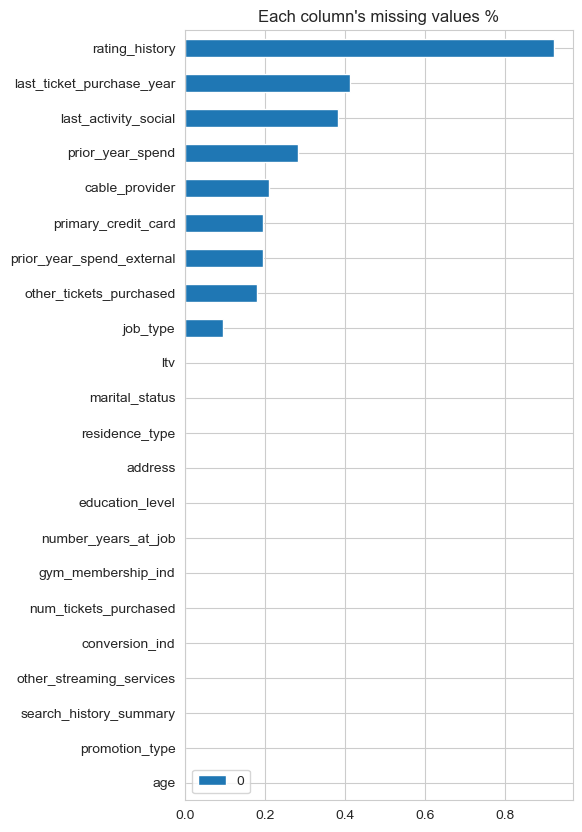

In [142]:
print((df.isnull().sum()[df.isnull().sum()/len(df)>0]/len(df)).sort_values(ascending =False))
pd.DataFrame((df.isnull().sum()/len(df)).sort_values(ascending = True))\
                .plot(kind='barh',figsize=(5,10),title='Each column\'s missing values %')

In [143]:
# drop columns with missing values > 70%
df = df.drop(['rating_history'], axis=1)

# drop useless columns
df = df.drop(['address'], axis=1)
#df = df.drop(['address', 'other_tickets_purchased'], axis=1)

In [144]:
'''
# you can easily check there're no such places
df['address']

'''

#df['other_tickets_purchased'].value_counts()

"\n# you can easily check there're no such places\ndf['address']\n\n"

# Feature exploration (categorical)

<AxesSubplot:>

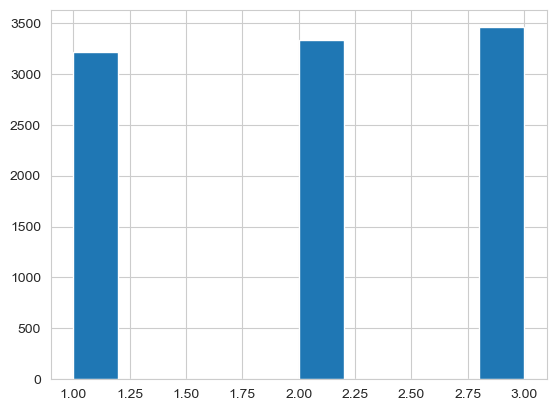

In [145]:
# check the distribution of the target variable (type)

df['promotion_type'] = df['promotion_type'].map({'gold':1,"silver":2,"bronze":3})
df['promotion_type'].hist()

In [146]:
# number of classes in each categorical feature
for i in df.select_dtypes(include=['object']).columns.tolist():
    print(i,len(df[i].value_counts()))

residence_type 3
education_level 6
job_type 12
other_tickets_purchased 5505
primary_credit_card 9
last_activity_social 2294
cable_provider 10
search_history_summary 9868


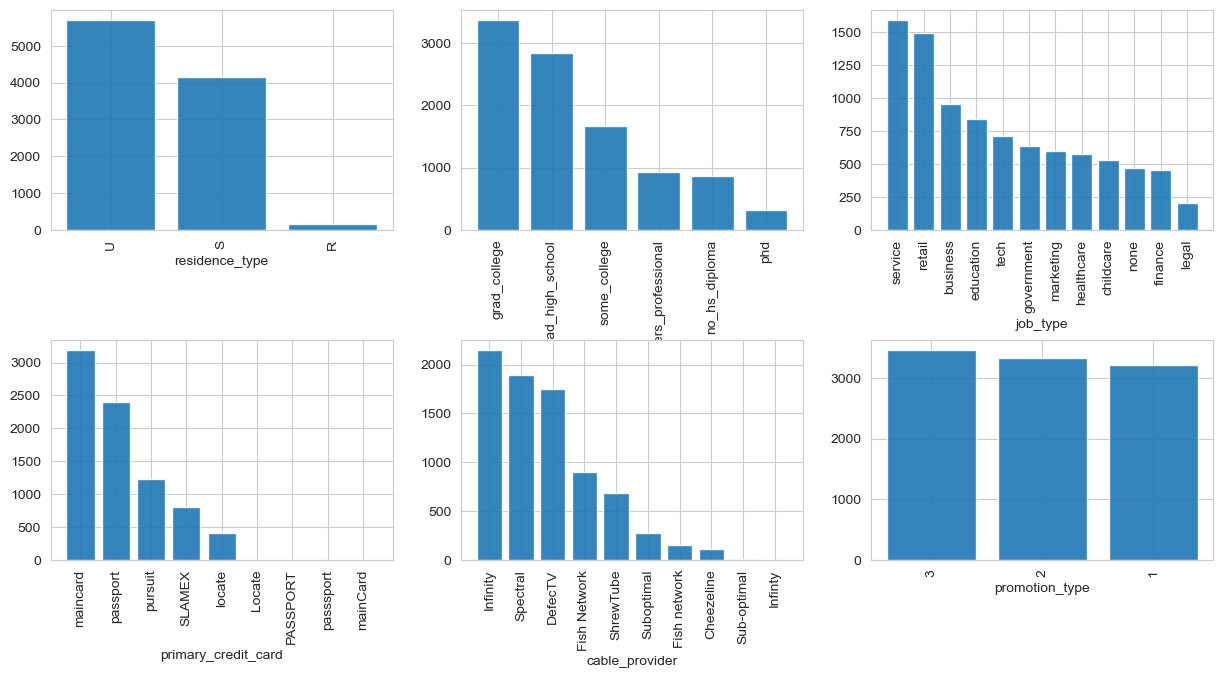

In [147]:
# check categorical features with less than 12 class

l_cat = ['residence_type', 'education_level', 'job_type', 'primary_credit_card', 'cable_provider', 'promotion_type']

fig = plt.figure(figsize=(15,20))
plt.subplots_adjust(hspace = 0.5)
for i in range(len(l_cat)):
    ax = fig.add_subplot(5, 3, i+1)
    obj = df[l_cat[i]].value_counts().index.tolist()
    ind = np.arange(len(obj))
    values = df[l_cat[i]].value_counts().values.tolist()
    ax.bar(ind,values,align='center', alpha=.9)
    ax.set_xticks(ind)
    ax.set_xticklabels(obj)
    ax.set_xlabel(l_cat[i])
    plt.setp(ax.get_xticklabels(), rotation='vertical')

/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:1209: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


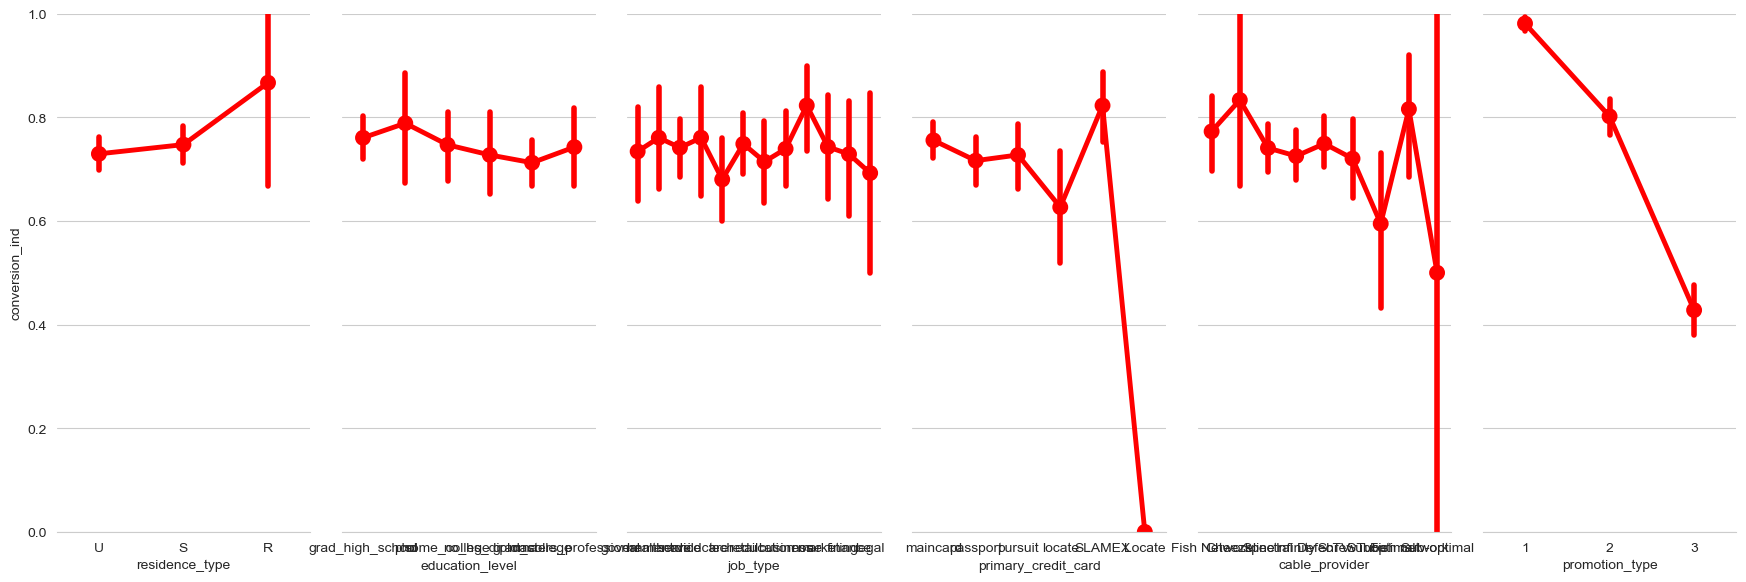

In [148]:
# Set up a grid to plot survival probability against several variables
df_tmp = df.copy().dropna()
g = sns.PairGrid(df_tmp, y_vars="conversion_ind",
                 x_vars=l_cat,
                 height=5, aspect=.5, size=5)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, scale=1.3, errwidth=4, color="red")
g.set(ylim=(0, 1))
g.fig.set_figheight(6), g.fig.set_figwidth(18)
sns.despine(fig=g.fig, left=True)

step a: fixing `parimary_credit_card`

In [149]:
# There's a string error in the column 'primary_credit_card', as spotted by the following codes
# We can fix it by replacing the string with lower case, like 'mastercard' with 'mastercard ' (with a space at the end)
'''
sns.pointplot(x="primary_credit_card", y="conversion_ind", hue="promotion_type", data=df)
df['primary_credit_card'].value_counts()
'''

'\nsns.pointplot(x="primary_credit_card", y="conversion_ind", hue="promotion_type", data=df)\ndf[\'primary_credit_card\'].value_counts()\n'

In [150]:
# convert to lower case
df['primary_credit_card'] = df['primary_credit_card'].astype('str')\
                                                     .apply(lambda x: None if x == 'nan' else x.lower())\
                                                     .apply(lambda x: 'passport' if x == 'passsport' else x)

# check if all successful
df['primary_credit_card'].value_counts()

maincard    3188
passport    2405
pursuit     1236
slamex       809
locate       415
Name: primary_credit_card, dtype: int64

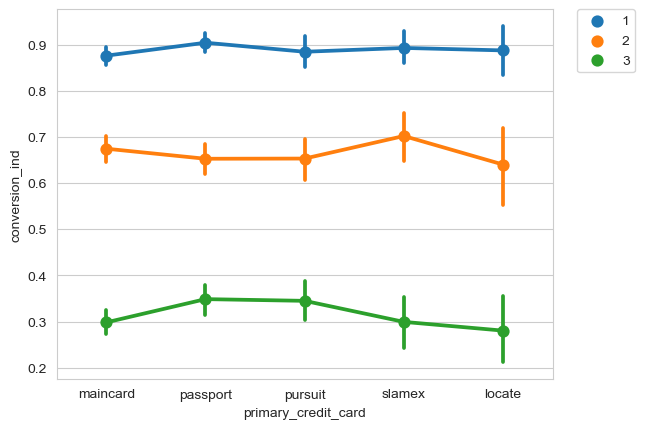

In [151]:
# check if the error is fixed and if the classes of primary_credit_card affect convertion rate
df_tmp = df[df['primary_credit_card'].notnull()]
sns.pointplot(x="primary_credit_card", y="conversion_ind", hue="promotion_type", data=df_tmp)
#sns.pointplot(x="primary_credit_card", y="conversion_ind", data=df_tmp)

# adjust the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Show the plot
plt.show()

step b: `cable_provider`

In [152]:
import re

def search_keywords(df, col_name, keywords, replace_dict=None):
    """
    Searches for the given keywords in the specified column of the given Pandas DataFrame using regular expressions.
    Optionally, replaces the matched keywords with new values from a dictionary.
    
    Parameters:
        - df: The Pandas DataFrame to search.
        - col_name: The name of the column to search.
        - keywords: A list of keywords to search for.
        - replace_dict (optional): A dictionary mapping each keyword to its replacement value.
        
    Returns:
        A new Pandas DataFrame with the specified column modified according to the replacement dictionary (if provided).
    """
    
    # Convert the keywords to a regex pattern
    pattern = '|'.join(keywords)
    
    # Use regex to search the column for the pattern
    mask = df[col_name].str.contains(pattern, na=False)
    
    # Create a new DataFrame with the searched column
    new_df = df[[col_name]].copy()
    
    # Replace the matched keywords with their corresponding values from the replacement dictionary (if provided)
    if replace_dict:
        new_df = df.copy()
        for keyword, value in replace_dict.items():
            new_df[col_name] = new_df[col_name].str.replace(keyword, value)
        return new_df
    
    # Return the new DataFrame
    return new_df[mask]

In [153]:
# check for text erros
df_tmp = df[df['cable_provider'].notnull()]
df_tmp['cable_provider'].value_counts()

Infinity        2146
Spectral        1893
DefecTV         1745
Fish Network     902
ShrewTube        680
Suboptimal       270
Fish network     148
Cheezeline       116
Sub-optimal       11
Infinty            1
Name: cable_provider, dtype: int64

In [154]:
# update the dataframe after fixing the text error
keywords = ['Infinty', 'Sub-optimal', 'Fish network']
replace_dict = {'Infinty': 'Infinity', 'Sub-optimal': 'Suboptimal', 'Fish network': 'Fish Network'}
df = search_keywords(df, 'cable_provider', keywords=keywords, replace_dict=replace_dict)

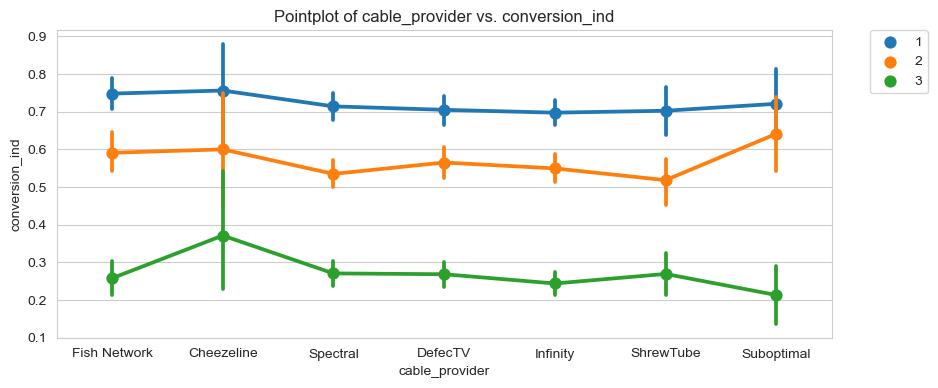

In [155]:
#df_cleaned['cable_provider'].value_counts()
# preprae data
df_tmp = df[df['cable_provider'].notnull()]

# Create a wider figure with a 6-inch width and 4-inch height
fig, ax = plt.subplots(figsize=(10, 4))

# Plot
sns.pointplot(x="cable_provider", y="conversion_ind", hue="promotion_type", data=df_tmp)

# Set ax
ax.set_title("Pointplot of cable_provider vs. conversion_ind")
# Move the legend to the right of the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Show the plot
plt.show()

Some thoughts:
- generally, the chances of conversion are consistent with the type of the coupons (gold/silver/bronze)
- user with `Cheezeline` as cable provider is more sensitive to bronze promotion and those with `Suboptimal` as cable provider are more sensitive to silver promotion

Now that we've explored catergorical variables with simple classes (<12) and cleaned the text erros. 

Let's look at more complex cat variables

## To-do list: explore the following features and decide whether to drop them or transform them
- `job_type`
- `other_tickets_purchased`
- `last_activity_social`
- `search_history_summary`

education_level

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


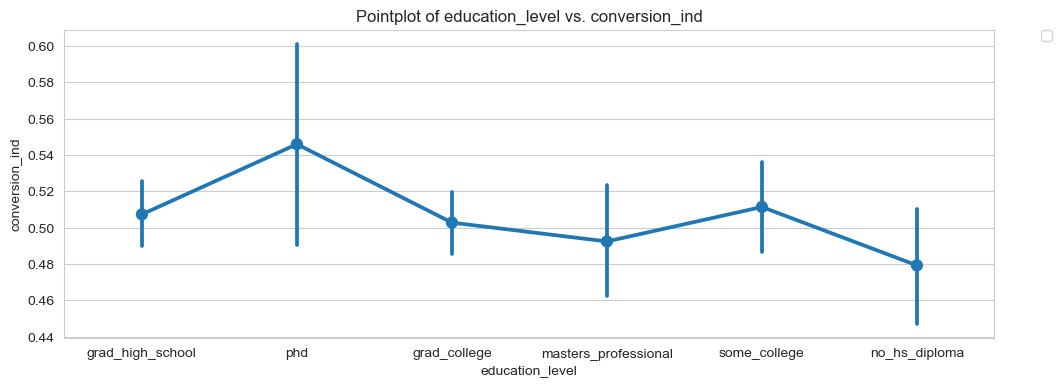

In [156]:
#df['education_level'].value_counts().sort_values(ascending=False)#.head(10)

# preprae data
df_tmp = df[df['education_level'].notnull()]

# Create a wider figure with a 6-inch width and 4-inch height
fig, ax = plt.subplots(figsize=(12, 4))

# Plot
sns.pointplot(x="education_level", y="conversion_ind", data=df_tmp) # this plot has more obvious difference between classes
#sns.pointplot(x="education_level", y="conversion_ind", hue="promotion_type", data=df_tmp)

# Set ax
ax.set_title("Pointplot of education_level vs. conversion_ind")
# Move the legend to the right of the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Show the plot
plt.show()

博士压力那么大吗...

job_type

In [157]:
df['job_type'].value_counts().sort_values(ascending=False)#.head(10)

service       1590
retail        1495
business       952
education      842
tech           709
government     633
marketing      599
healthcare     574
childcare      532
none           470
finance        456
legal          202
Name: job_type, dtype: int64

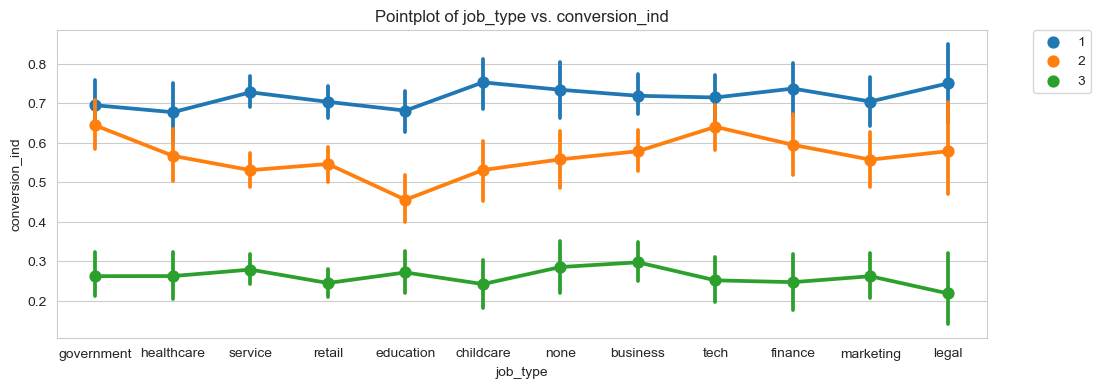

In [158]:
# preprae data
df_tmp = df[df['job_type'].notnull()]

# Create a wider figure with a 6-inch width and 4-inch height
fig, ax = plt.subplots(figsize=(12, 4))

# Plot
sns.pointplot(x="job_type", y="conversion_ind", hue="promotion_type", data=df_tmp)

# Set ax
ax.set_title("Pointplot of job_type vs. conversion_ind")
# Move the legend to the right of the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Show the plot
plt.show()


- Similarly, types of promotion affect the chance of conversion
- people with job type `education` are less likely to be converted given promotion, compared to other job types; by contrast, people work in `tech` and `government` are more likely to convert if provided wtih promotions

search_history_summary

In [159]:
df['search_history_summary'].value_counts().sort_values(ascending=False)

['majorbooksmagazine.com']                                                                 5
['actionfinancenews.com']                                                                  3
['totalmarketmagazine.com']                                                                3
['dailytechclips.com']                                                                     3
['dailytechreport.com']                                                                    3
                                                                                          ..
['majorwrestlerclips.com', 'firstrecipesinfo.com', 'firsttech.com', 'UBCwrestling.com']    1
['wrestlingnews.com', 'globalwrestlingmagazine.com', 'books.com']                          1
['nationalbooks.com', 'premierfightingreport.com', 'premierrecipesinfo.com']               1
['UBCrecipes.com', 'premiermarketmagazine.com', 'premierwrestlingnews.com']                1
['firstpolitics.com', 'nationalfinancenews.com', 'nationaloutdoorrepor

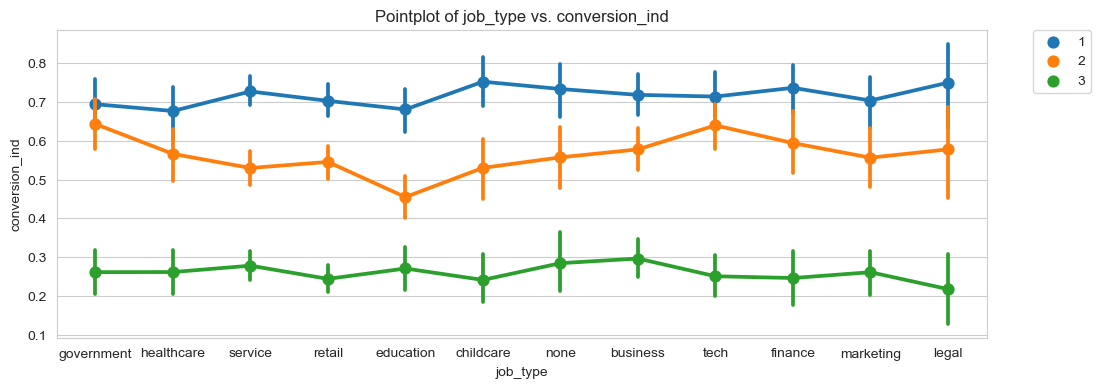

In [160]:
# preprae data
df_tmp = df[df['search_history_summary'].notnull()]
df_tmp['searched_wrest'] = df_tmp['search_history_summary'].str.contains('wrest|fight')
df_tmp['searched_wrest'] = df_tmp['searched_wrest'].map({True:1,False:0})


# Create a wider figure with a 6-inch width and 4-inch height
fig, ax = plt.subplots(figsize=(12, 4))

# Plot
sns.pointplot(x="job_type", y="conversion_ind", hue="promotion_type", data=df_tmp)

# Set ax
ax.set_title("Pointplot of job_type vs. conversion_ind")
# Move the legend to the right of the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Show the plot
plt.show()


In [161]:
''' we will create a feature in the following section
df['searched_wrest'] = df['search_history_summary'].str.contains('wrest|fight')
df['searched_wrest'] = df['searched_wrest'].map({True:1,False:0})
'''


" we will create a feature in the following section\ndf['searched_wrest'] = df['search_history_summary'].str.contains('wrest|fight')\ndf['searched_wrest'] = df['searched_wrest'].map({True:1,False:0})\n"

other_tickets_purchased

In [162]:
df['other_tickets_purchased'].value_counts().sort_values(ascending=False)

['fb']                                                                 435
['c']                                                                  277
['bsb']                                                                212
['bxb']                                                                154
['fb', 'fb']                                                           121
                                                                      ... 
['fb', 'c', 'fb', 'bxb', 'fb', 's', 'c', 'bsb', 'c', 'c']                1
['bxb', 'fb', 'bsb', 'bxb', 'bxb', 'bxb', 'bxb', 'c', 'bsb', 'bsb']      1
['c', 'bxb', 'fb', 'bsb', 'fb', 'fb', 'bxb', 'bxb', 'bxb', 'fb']         1
['fb', 'bxb', 'fb', 's', 'bsb', 's', 'bxb']                              1
['fb', 'bsb', 'bxb', 'fb', 's', 'fb', 'c', 'fb', 'bsb', 'bxb']           1
Name: other_tickets_purchased, Length: 5505, dtype: int64

Recall that the definition of this feature is:
>`other_tickets_purchased`: Returns a list of non-wrestling tickets for paid events the individual has purchased since 2010. Each code represents a specific category, and codes can duplicate

But the problem is that (1) we don't know what category does each code stands for, and (2) this is a feature of pruchasing record that is irrelevant to wrestling. In conclusion, it is better to remove this column

last_activity_social

In [163]:
#df['last_activity_social'].isna().value_counts()

In [164]:
# we need to conver object -> string -> extract year -> int
df_tmp = df[['last_activity_social']].copy()

# convert target column to int type (year)
df_tmp['last_activity_social'] = df_tmp['last_activity_social'].astype(str).replace('nan', '0-0-0')
df_tmp['last_activity_social_year'] = df_tmp['last_activity_social'].str.split('-').str[0].astype(int)

# calculate if the user has active activity with our social media platform in the last 3 or 5 years
df_tmp['activity_social_3y'] = df_tmp['last_activity_social_year'].apply(lambda x: 1 if x >= 2017 else 0)
df_tmp['activity_social_5y'] = df_tmp['last_activity_social_year'].apply(lambda x: 1 if x >= 2015 else 0)

# add the new features to the main dataframe
df['activity_social_3y'] = df_tmp['activity_social_3y']
df['activity_social_5y'] = df_tmp['activity_social_5y']

# remove the unwanted columns
#df.drop(['last_activity_social'], axis=1, inplace=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


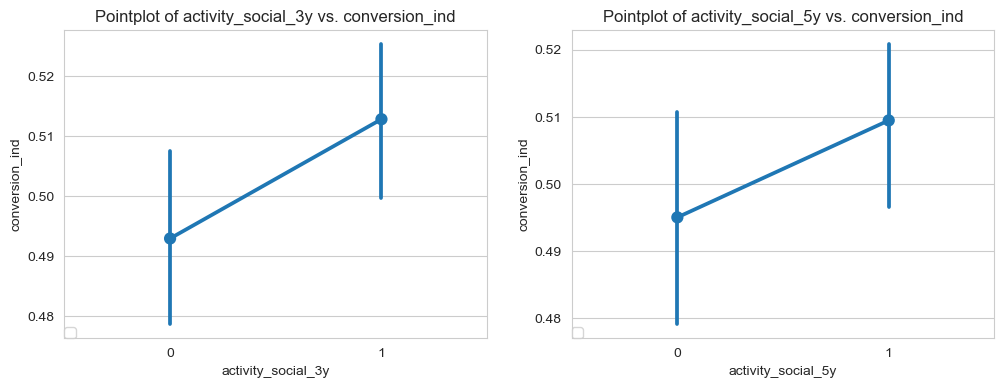

In [165]:
# preprae data
df_tmp = df[['activity_social_3y', 'activity_social_5y', 'conversion_ind', 'promotion_type']]

# Create two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot
sns.pointplot(x="activity_social_3y", y="conversion_ind", data=df_tmp, ax=ax1)

sns.pointplot(x="activity_social_5y", y="conversion_ind", data=df_tmp, ax=ax2)

# Set ax
ax1.set_title("Pointplot of activity_social_3y vs. conversion_ind")
ax2.set_title("Pointplot of activity_social_5y vs. conversion_ind")

# Move the legend to the bottom right of the plot
ax1.legend(loc=3, borderaxespad=0.)
ax2.legend(loc=3, borderaxespad=0.)

# Show the plot
plt.show()

Similarly, we want to transform year columns (`last_ticket_purchase_year`) to categorical columns

In [166]:
#df['last_ticket_purchase_year'].value_counts().sort_values(ascending=False)
#df['last_ticket_purchase_year'].isna().value_counts()
df['last_ticket_purchase_year'].dtype

dtype('float64')

In [167]:
# we need to conver float to int
df_tmp = df[['last_ticket_purchase_year']].copy()

# fill missing values
df_tmp['last_ticket_purchase_year'] = df_tmp['last_ticket_purchase_year'].fillna(0)

# calculate if the user has purchased tickets from us in the past 3 or 5 years
df_tmp['ticket_purchase_3y'] = df_tmp['last_ticket_purchase_year'].apply(lambda x: 1 if x >= 2017 else 0)
df_tmp['ticket_purchase_5y'] = df_tmp['last_ticket_purchase_year'].apply(lambda x: 1 if x >= 2015 else 0)

# add the new features to the main dataframe
df['ticket_purchase_3y'] = df_tmp['ticket_purchase_3y']
df['ticket_purchase_5y'] = df_tmp['ticket_purchase_5y']

# remove the unwanted columns
#df.drop(['last_ticket_purchase_year'], axis=1, inplace=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


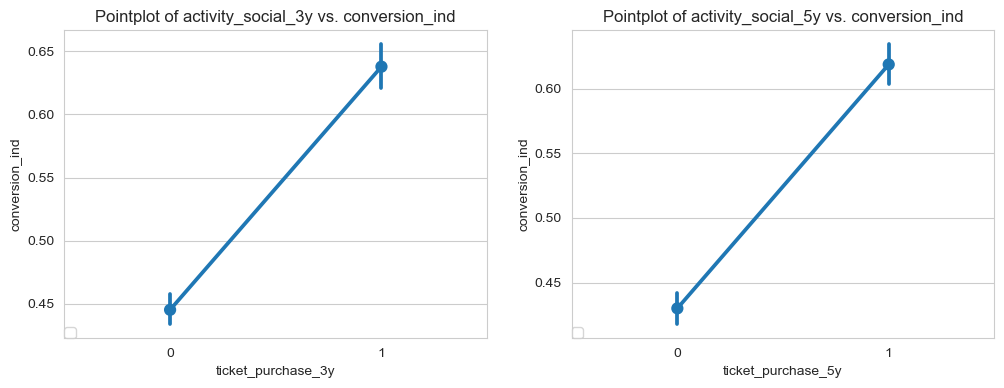

In [168]:
# preprae data
df_tmp = df[['ticket_purchase_3y', 'ticket_purchase_5y', 'conversion_ind', 'promotion_type']]

# Create two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot
sns.pointplot(x="ticket_purchase_3y", y="conversion_ind", data=df_tmp, ax=ax1)
sns.pointplot(x="ticket_purchase_5y", y="conversion_ind", data=df_tmp, ax=ax2)

# Set ax
ax1.set_title("Pointplot of activity_social_3y vs. conversion_ind")
ax2.set_title("Pointplot of activity_social_5y vs. conversion_ind")

# Move the legend to the bottom right of the plot
ax1.legend(loc=3, borderaxespad=0.)
ax2.legend(loc=3, borderaxespad=0.)

# Show the plot
plt.show()

This result is significant

# Feature exploration (continous)

Distribution

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is c

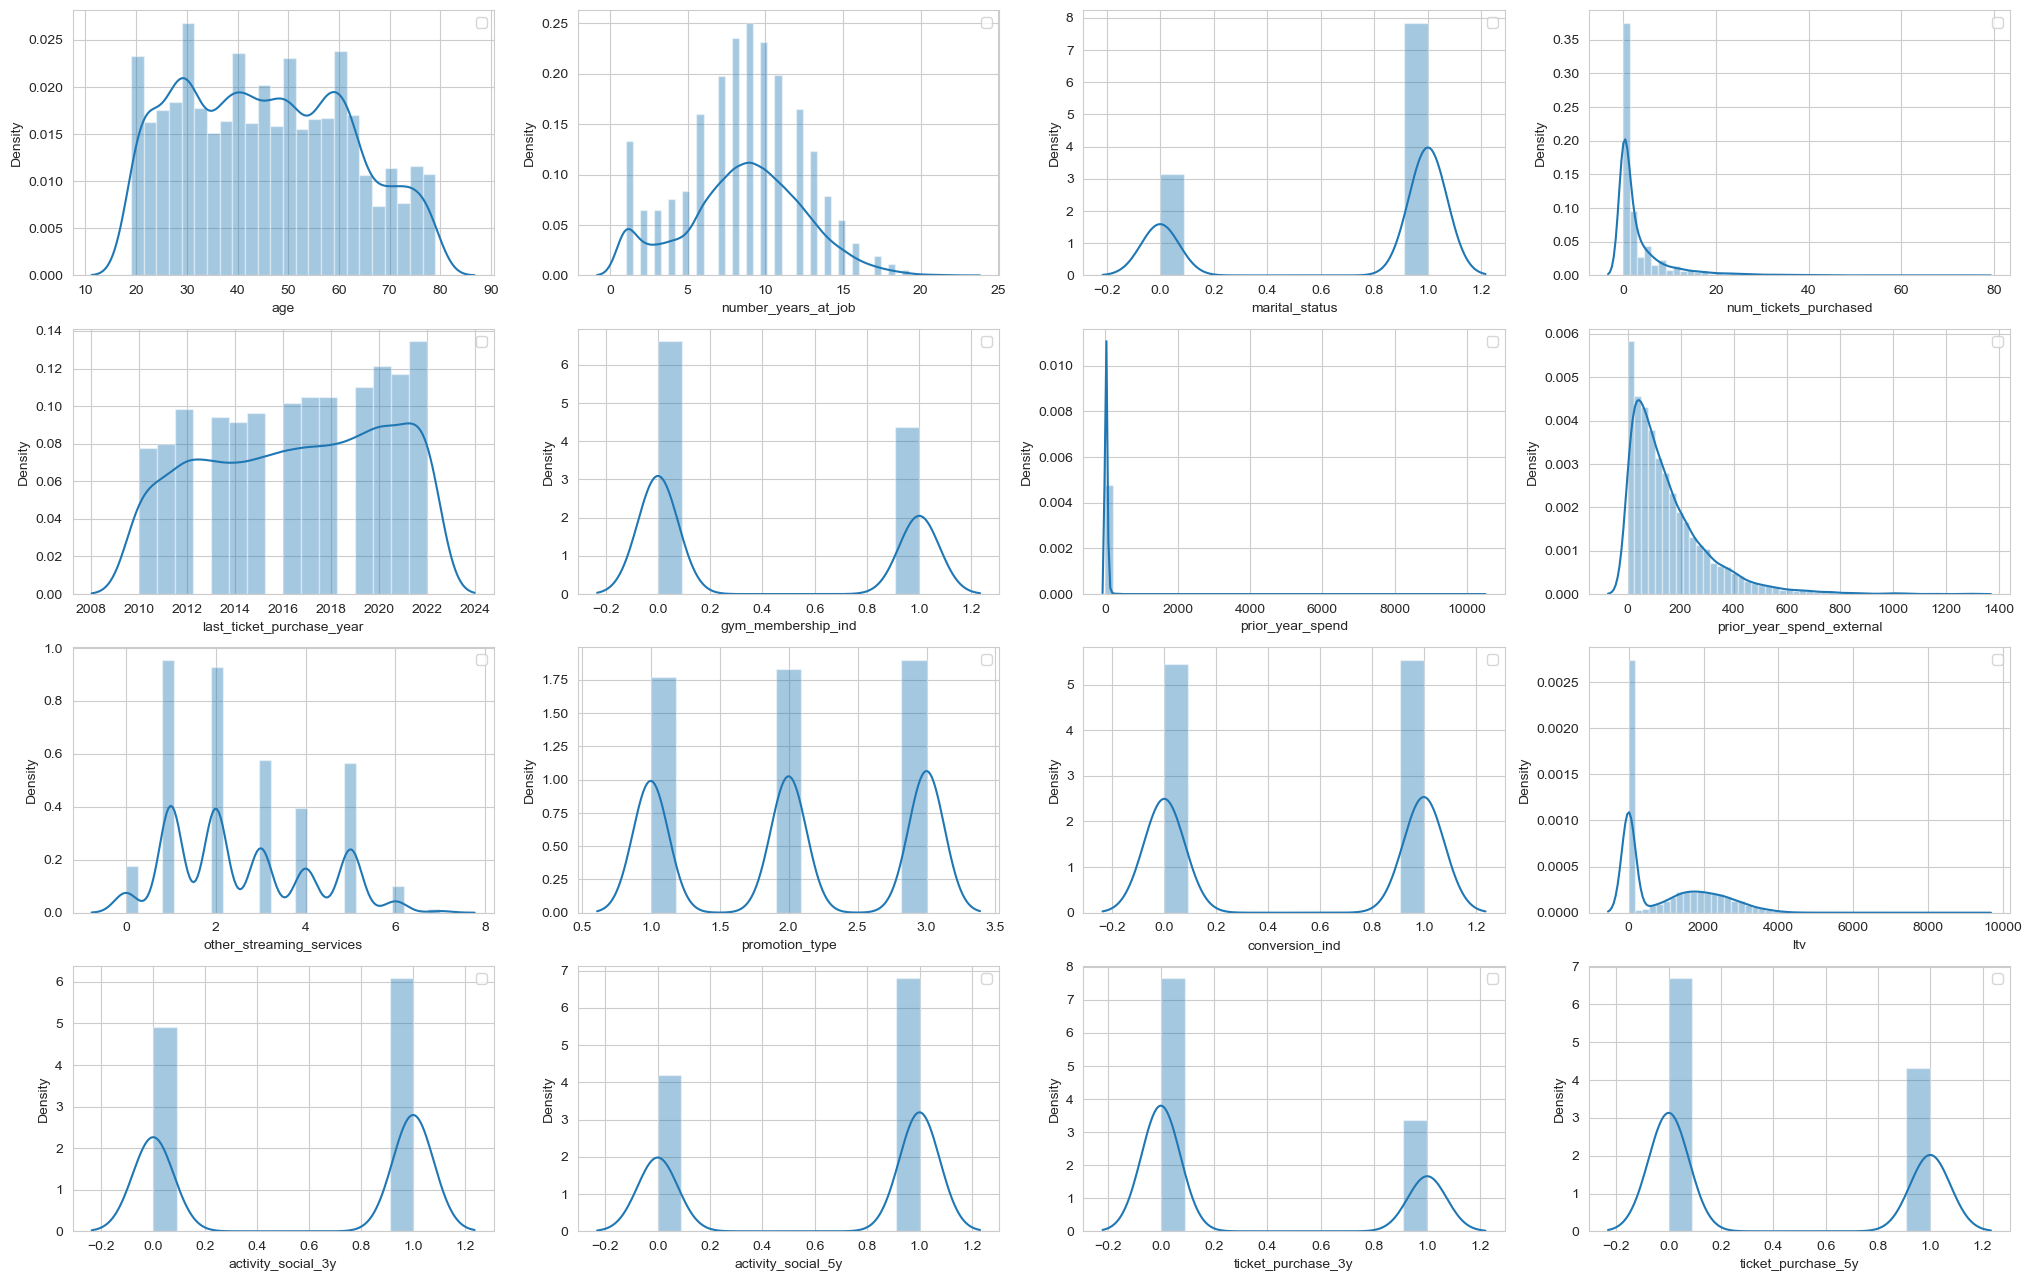

In [169]:
l_num = df.select_dtypes(exclude=['object']).columns.tolist()

fig = plt.figure(figsize=(25,20))
for i in range(len(l_num)):
    ax=fig.add_subplot(5, 4, i+1)
    sns.distplot(df[l_num[i]].dropna())
    # add a 'best fit' line
    ax.set_xlabel(l_num[i])
    ax.legend()

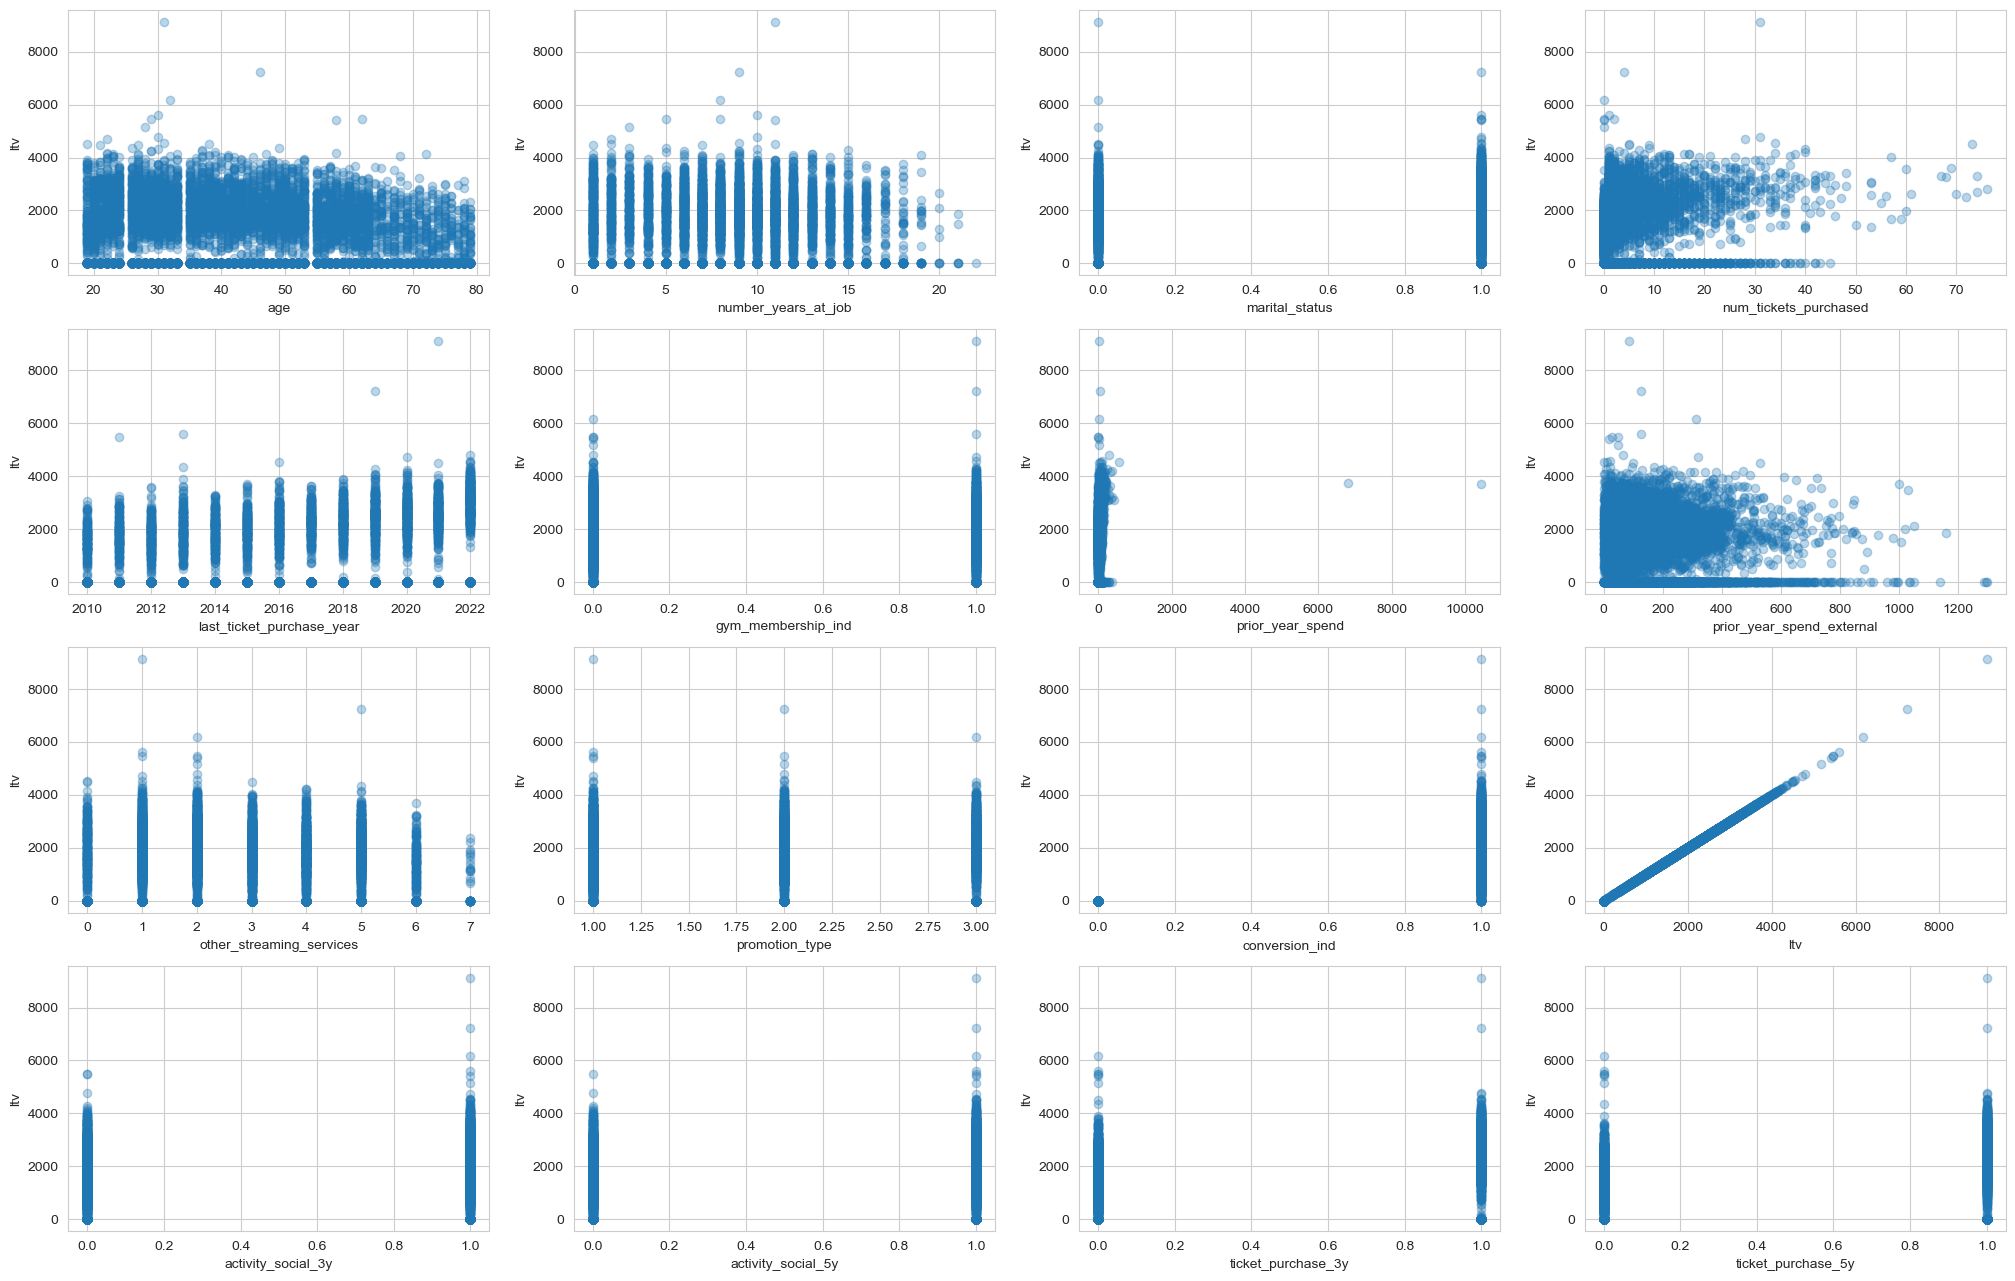

In [170]:
# check for outliers and correlation
#l_num = [i for i in df.select_dtypes(exclude=['object']).columns.tolist() if i not in ['ltv']]
l_num = [i for i in df.select_dtypes(exclude=['object']).columns.tolist()]

fig = plt.figure(figsize=(25,20))
for i in range(len(l_num)):
    ax=fig.add_subplot(5, 4, i+1)
    ax.scatter(df[l_num[i]], df['ltv'], alpha=0.3)
    ax.set_xlabel(l_num[i])
    ax.set_ylabel('ltv')

`prior_year_spend` and `prior_year_spend_external`
>prior_year_spend: The spend this individual has had with our company throughout the last year

>prior_year_spend_external: Spend relevant to our company that this individual has had with other companies throughout the last year, as reported by a third-party data vendor

From the plot, we see no clear linear relationship between ltv and the two features related to prior spending. 

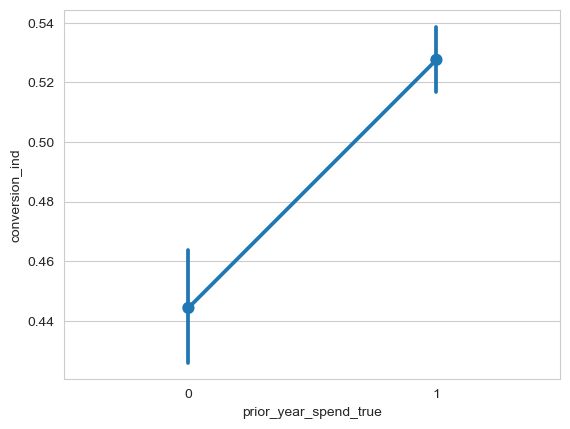

In [206]:
# prepare data
df_tmp = df.copy().dropna(subset=['ltv', 'prior_year_spend'])

# convert to categorical variable
df_tmp['prior_year_spend'] = df_tmp['prior_year_spend'].replace('None', 0).astype(float)
df_tmp['prior_year_spend_true'] = df_tmp['prior_year_spend'].apply(lambda x: 1 if x > 0 else 0)
#df_tmp['prior_year_spend_over_8'] = df_tmp['prior_year_spend'].apply(lambda x: 1 if x > 8 else 0)

# see whether prior_year_spend_true has any impact on conversion
#sns.pointplot(data=df_tmp, x='prior_year_spend_true', y='conversion_ind',hue='promotion_type', alpha=0.3)
sns.pointplot(data=df_tmp, x='prior_year_spend_true', y='conversion_ind', alpha=0.3)

#sns.pointplot(data=df_tmp, x='prior_year_spend_over_8', y='conversion_ind', alpha=0.3)

plt.show()

It turns out the prior spending leads to a higher chance of conversion

In [210]:
'''
Less than half of the users spend more than 8 dollars in the prior year.
The new feature called prior_year_spend_true is sufficient to capture the information in conversion, but we want to know if this will affect the ltv?
Also, for simplicity, we don't want to explore further on whether the a higher amount spent (say, $8) in the prior year has any impact on conversion.
''' 
df_tmp['prior_year_spend'].describe()

count   10,001.00
mean        19.82
std        127.53
min          0.00
25%          0.00
50%          8.13
75%         24.87
max     10,438.77
Name: prior_year_spend, dtype: float64

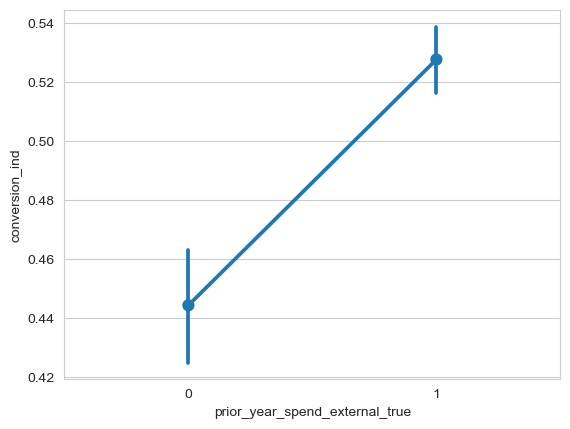

In [211]:
# prepare data
df_tmp = df.copy().dropna(subset=['ltv', 'prior_year_spend', 'prior_year_spend_external'])

# convert to categorical variable
df_tmp['prior_year_spend'] = df_tmp['prior_year_spend'].replace('None', 0).astype(float)
df_tmp['prior_year_spend_external'] = df_tmp['prior_year_spend_external'].replace('None', 0).astype(float)
df_tmp['prior_year_spend_external_true'] = df_tmp['prior_year_spend'].apply(lambda x: 1 if x > 0 else 0)

# see whether prior_year_spend_true has any impact on conversion
sns.pointplot(data=df_tmp, x='prior_year_spend_external_true', y='conversion_ind', alpha=0.3)

plt.show()

The result is similar. Now let's see the relationship between users spending on our platform and other platforms.

<AxesSubplot:xlabel='prior_year_spend_external', ylabel='prior_year_spend'>

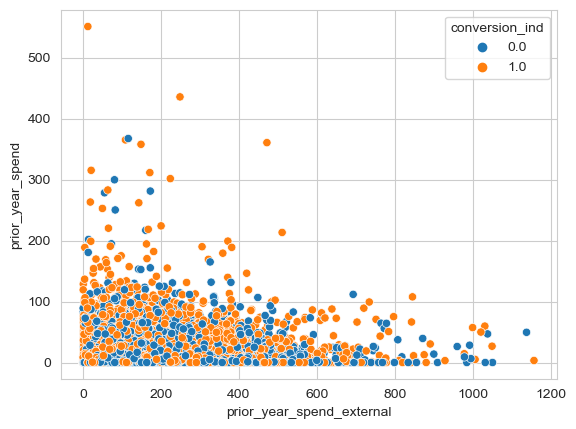

In [215]:
# make a scatterplot of the prior_year_spend_external vs. prior_year_spend
df_tmp2 = df_tmp[(df_tmp['prior_year_spend_external'] < 1200) & (df_tmp['prior_year_spend'] < 2000)]
sns.scatterplot(data=df_tmp2, x='prior_year_spend_external', y='prior_year_spend',
                hue='conversion_ind')

We can conclude that:
- prior spending, no matter on what platform, indicates higher chance of conversion
- no clear relationship between prior year spending and prior year spending externally
- no clear relationship between ltv and these two features above

## Check outliers

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/pyt

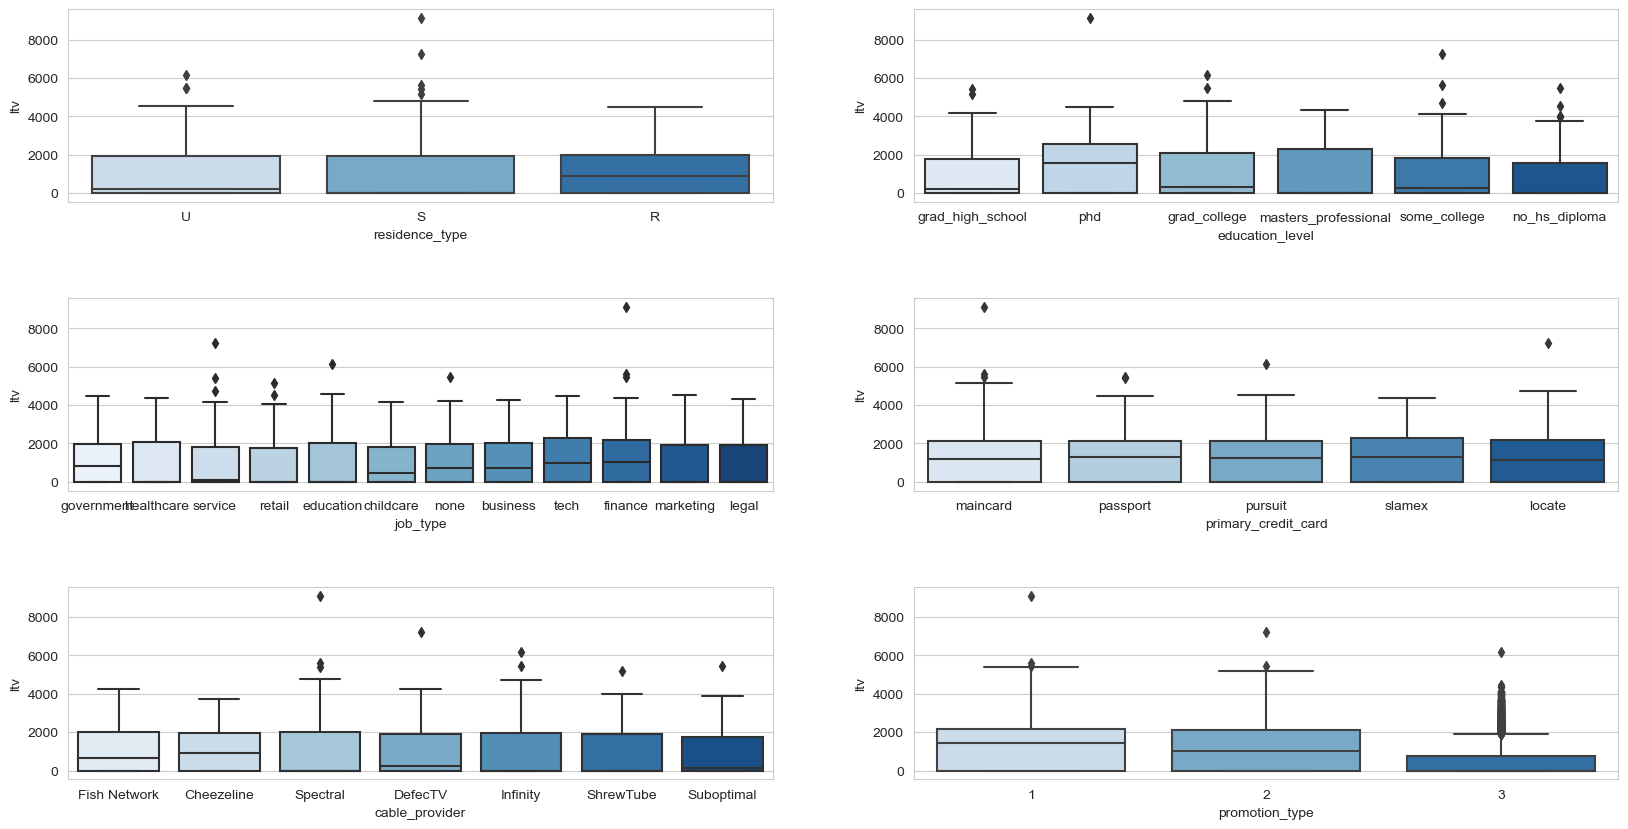

In [171]:
fig, axes  = plt.subplots(nrows=3, ncols=2,figsize=(20,10))
fig.subplots_adjust(hspace=.5)

k = 0 # initialize k outside the loop
for i in range(5):
    if k < len(l_cat) and k <= 6: # add check for k < len(l_cat)
        for j in range(2):
            sns.set_style("whitegrid")
            g=sns.boxplot(df[l_cat[k]],df['ltv'],palette='Blues',ax=axes[i,j])
            if l_cat[k]=='sub_type':
                g.set_xticklabels(df[l_cat[k]],rotation=70)
            k+=1

## Correlation

In [172]:
# filter out numerical variables and categorical variables
df.dtypes.value_counts()
num_df=df.select_dtypes(include=np.number)
cg_train_data=df.select_dtypes(include='object')
#num_df.head(3)

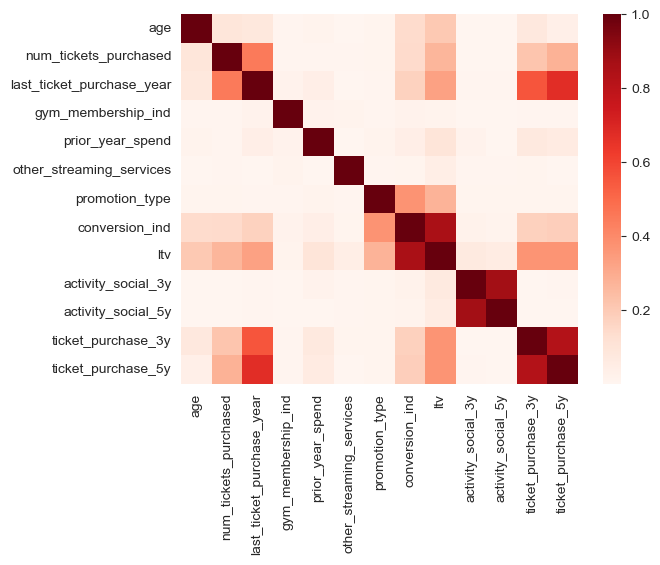

In [173]:
# heatmap of numerical variables correlation   
# temporarily fill missing numerical variables with 0
num_df = num_df.fillna(0)
highcorr_num_df = num_df.loc[:,num_df.corr().abs()['promotion_type'] > 0.005]
corrs = highcorr_num_df.corr().abs()
heatmap = sns.heatmap(corrs,cmap='Reds')

<AxesSubplot:>

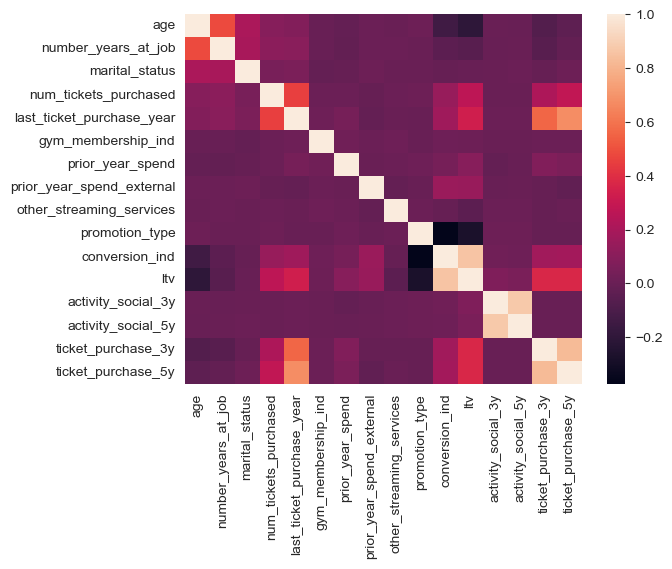

In [174]:
sns.heatmap(num_df.corr())

# Missing Value and Anomaly

- `job_type`: some people have >0 years of work experience but have no job type
- `num_tickets_purchased`: number of ticket purchased matched with purchasing records

In [175]:
# Deal with abnormal categorical value (according to related variables)
tmp_bool = df['job_type'].isna()
df.loc[tmp_bool, ['job_type', 'number_years_at_job']]
tmp_bool = (df['job_type'].isna() & df['number_years_at_job']>0)
df.loc[tmp_bool, ['job_type', 'number_years_at_job']]

,job_type,number_years_at_job
11,NaN,9
15,NaN,5
21,NaN,9
51,NaN,7
54,NaN,5
...,...,...
9814,NaN,1
9822,NaN,9
9827,NaN,1
9877,NaN,11


In [176]:
tmp_bool2 = df['num_tickets_purchased'].isna()
df.loc[tmp_bool2, ['num_tickets_purchased', 'last_ticket_purchase_year']]
tmp_bool2 = (df['num_tickets_purchased'].isna() & df['last_ticket_purchase_year']>0)
df.loc[tmp_bool2, ['num_tickets_purchased', 'last_ticket_purchase_year']]

,num_tickets_purchased,last_ticket_purchase_year


In [177]:
'''
If there's a column that has missing values, we will check the description of the column and see if there's any abnormal value.
'''
num_cols = df.columns[df.isna().any()]
df[num_cols].describe().T.sort_values(by='count')

,count,mean,std,min,25%,50%,75%,max
last_ticket_purchase_year,"5,867.00","2,016.53",3.73,"2,010.00","2,013.00","2,017.00","2,020.00","2,022.00"
prior_year_spend,"7,164.00",27.66,149.96,0.00,6.43,15.65,34.28,"10,438.77"
prior_year_spend_external,"8,053.00",152.96,148.57,0.01,47.71,110.50,212.07,"1,295.81"


# Deal with NA values

catergorical missing value

In [178]:
# After reading the data description and some sanity check we can fill 
# Some of the missing categorical features with 'None', and some with most frequent category

# Fill with None (TOP15 categorical variables with most missing values)
fill_cols = ['last_ticket_purchase_year',
             'last_activity_social',
             'prior_year_spend',
             'primary_credit_card',
             'other_tickets_purchased',
             'job_type',
             'cable_provider']
for col in fill_cols:
    df[col].fillna('None', inplace=True)


numerical missing value

In [179]:
num_cols = df.columns[df.isna().any()]
df[num_cols].describe().T.sort_values(by='count')

,count,mean,std,min,25%,50%,75%,max
prior_year_spend_external,"8,053.00",152.96,148.57,0.01,47.71,110.50,212.07,"1,295.81"


In [180]:
df['prior_year_spend'] = df['prior_year_spend'].interpolate()
df['prior_year_spend_external'] = df['prior_year_spend_external'].interpolate()

Create new features

In [181]:
df['searched_wrest'] = df['search_history_summary'].str.contains('wrest|fight')
df['searched_wrest'] = df['searched_wrest'].map({True:1,False:0})

## Sanity check after imputing the data

In [183]:
abs(df.corr()['conversion_ind']).sort_values(ascending=False)

conversion_ind              1.00
ltv                         0.86
promotion_type              0.37
ticket_purchase_5y          0.18
ticket_purchase_3y          0.18
num_tickets_purchased       0.14
age                         0.14
number_years_at_job         0.04
prior_year_spend_external   0.04
activity_social_3y          0.02
gym_membership_ind          0.02
activity_social_5y          0.01
other_streaming_services    0.01
searched_wrest              0.01
marital_status              0.01
Name: conversion_ind, dtype: float64

In [184]:
abs(df.corr()['ltv']).sort_values(ascending=False)

ltv                         1.00
conversion_ind              0.86
ticket_purchase_5y          0.37
ticket_purchase_3y          0.37
promotion_type              0.27
num_tickets_purchased       0.27
age                         0.20
searched_wrest              0.08
activity_social_3y          0.07
number_years_at_job         0.06
activity_social_5y          0.06
other_streaming_services    0.05
prior_year_spend_external   0.02
gym_membership_ind          0.01
marital_status              0.00
Name: ltv, dtype: float64

# Redo EDA and Feature Engineering

In [227]:
train_data = pd.read_csv('data_smackdown_2023_training.csv')
print(f'Raw dataframe shape: {train_data.shape}')

# drop columns with missing values > 70%
train_data = train_data.drop(['rating_history'], axis=1)
# drop useless columns
train_data = train_data.drop(['address', 'other_tickets_purchased'], axis=1)

# map promotion type to int
train_data['promotion_type'] = train_data['promotion_type'].map({'gold':1,"silver":2,"bronze":3})

# ---

# cleaning (text errors), feature engineering (create/transform features)
# part_1
train_data['primary_credit_card'] = train_data['primary_credit_card'].astype('str')\
                                                     .apply(lambda x: None if x == 'nan' else x.lower())\
                                                     .apply(lambda x: 'passport' if x == 'passsport' else x)
# part_2
keywords = ['Infinty', 'Sub-optimal', 'Fish network']
replace_dict = {'Infinty': 'Infinity', 'Sub-optimal': 'Suboptimal', 'Fish network': 'Fish Network'}
train_data = search_keywords(train_data, 'cable_provider', keywords=keywords, replace_dict=replace_dict)

# part_3
# we need to conver object -> string -> extract year -> int
df_tmp = train_data[['last_activity_social', 'last_ticket_purchase_year']].copy()
# convert target column to int type (year)
df_tmp['last_activity_social'] = df_tmp['last_activity_social'].astype(str).replace('nan', '0-0-0')
df_tmp['last_activity_social_year'] = df_tmp['last_activity_social'].str.split('-').str[0].astype(int)
# calculate if the user has active activity with our social media platform in the last 3 or 5 years
df_tmp['activity_social_3y'] = df_tmp['last_activity_social_year'].apply(lambda x: 1 if x >= 2017 else 0)
df_tmp['activity_social_5y'] = df_tmp['last_activity_social_year'].apply(lambda x: 1 if x >= 2015 else 0)
# add the new features to the main dataframe
train_data['activity_social_3y'] = df_tmp['activity_social_3y']
train_data['activity_social_5y'] = df_tmp['activity_social_5y']

# part_4
df_tmp['last_ticket_purchase_year'] = df_tmp['last_ticket_purchase_year'].fillna(0)
# calculate if the user has purchased tickets from us in the past 3 or 5 years
df_tmp['ticket_purchase_3y'] = df_tmp['last_ticket_purchase_year'].apply(lambda x: 1 if x >= 2017 else 0)
df_tmp['ticket_purchase_5y'] = df_tmp['last_ticket_purchase_year'].apply(lambda x: 1 if x >= 2015 else 0)
# add the new features to the main dataframe
train_data['ticket_purchase_3y'] = df_tmp['ticket_purchase_3y']
train_data['ticket_purchase_5y'] = df_tmp['ticket_purchase_5y']
# remove the unwanted columns
train_data.drop(['last_activity_social', 'last_ticket_purchase_year'], axis=1, inplace=True)

# part_5
# prepare data
df_tmp = train_data.copy().dropna(subset=['ltv', 'prior_year_spend', 'prior_year_spend_external'])
# convert to categorical variable
df_tmp['prior_year_spend'] = df_tmp['prior_year_spend'].replace('None', 0).astype(float)
df_tmp['prior_year_spend_true'] = df_tmp['prior_year_spend'].apply(lambda x: 1 if x > 0 else 0)
df_tmp['prior_year_spend_external'] = df_tmp['prior_year_spend_external'].replace('None', 0).astype(float)
df_tmp['prior_year_spend_external_true'] = df_tmp['prior_year_spend'].apply(lambda x: 1 if x > 0 else 0)
# add to main dataframe
train_data['prior_year_spend_true'] = df_tmp['prior_year_spend_true']
train_data['prior_year_spend_external_true'] = df_tmp['prior_year_spend_external_true']

# part_6
train_data['searched_wrest'] = train_data['search_history_summary'].str.contains('wrest|fight')
train_data['searched_wrest'] = train_data['searched_wrest'].map({True:1,False:0})
train_data.drop(['search_history_summary'], axis=1, inplace=True)

# ---

# deal with NA
# Fill with None (TOP15 categorical variables with most missing values)
fill_cols = ['prior_year_spend',
             'primary_credit_card',
             'job_type',
             'cable_provider']
for col in fill_cols:
    train_data[col].fillna('None', inplace=True)
# numerical
train_data['prior_year_spend'] = train_data['prior_year_spend'].interpolate()
train_data['prior_year_spend_external'] = train_data['prior_year_spend_external'].interpolate()

# check output
print(f'Output dataframe shape: {train_data.shape}')


Raw dataframe shape: (10001, 22)
Output dataframe shape: (10001, 23)


In [228]:
test_data = pd.read_csv('data_smackdown_2023_validation.csv')
print(f'Raw dataframe shape: {test_data.shape}')

# drop columns with missing values > 70%
test_data = test_data.drop(['rating_history'], axis=1)
# drop useless columns
test_data = test_data.drop(['address', 'other_tickets_purchased'], axis=1)

# map promotion type to int
test_data['promotion_type'] = test_data['promotion_type'].map({'gold':1,"silver":2,"bronze":3})

# ---

# cleaning (text errors), feature engineering (create/transform features)
# part_1
test_data['primary_credit_card'] = test_data['primary_credit_card'].astype('str')\
                                                     .apply(lambda x: None if x == 'nan' else x.lower())\
                                                     .apply(lambda x: 'passport' if x == 'passsport' else x)
# part_2
keywords = ['Infinty', 'Sub-optimal', 'Fish network']
replace_dict = {'Infinty': 'Infinity', 'Sub-optimal': 'Suboptimal', 'Fish network': 'Fish Network'}
test_data = search_keywords(test_data, 'cable_provider', keywords=keywords, replace_dict=replace_dict)

# part_3
# we need to conver object -> string -> extract year -> int
df_tmp = test_data[['last_activity_social', 'last_ticket_purchase_year']].copy()
# convert target column to int type (year)
df_tmp['last_activity_social'] = df_tmp['last_activity_social'].astype(str).replace('nan', '0-0-0')
df_tmp['last_activity_social_year'] = df_tmp['last_activity_social'].str.split('-').str[0].astype(int)
# calculate if the user has active activity with our social media platform in the last 3 or 5 years
df_tmp['activity_social_3y'] = df_tmp['last_activity_social_year'].apply(lambda x: 1 if x >= 2017 else 0)
df_tmp['activity_social_5y'] = df_tmp['last_activity_social_year'].apply(lambda x: 1 if x >= 2015 else 0)
# add the new features to the main dataframe
test_data['activity_social_3y'] = df_tmp['activity_social_3y']
test_data['activity_social_5y'] = df_tmp['activity_social_5y']

# part_4
df_tmp['last_ticket_purchase_year'] = df_tmp['last_ticket_purchase_year'].fillna(0)
# calculate if the user has purchased tickets from us in the past 3 or 5 years
df_tmp['ticket_purchase_3y'] = df_tmp['last_ticket_purchase_year'].apply(lambda x: 1 if x >= 2017 else 0)
df_tmp['ticket_purchase_5y'] = df_tmp['last_ticket_purchase_year'].apply(lambda x: 1 if x >= 2015 else 0)
# add the new features to the main dataframe
test_data['ticket_purchase_3y'] = df_tmp['ticket_purchase_3y']
test_data['ticket_purchase_5y'] = df_tmp['ticket_purchase_5y']
# remove the unwanted columns
test_data.drop(['last_activity_social', 'last_ticket_purchase_year'], axis=1, inplace=True)

# part_5
# prepare data
df_tmp = test_data.copy().dropna(subset=['prior_year_spend', 'prior_year_spend_external'])
# convert to categorical variable
df_tmp['prior_year_spend'] = df_tmp['prior_year_spend'].replace('None', 0).astype(float)
df_tmp['prior_year_spend_true'] = df_tmp['prior_year_spend'].apply(lambda x: 1 if x > 0 else 0)
df_tmp['prior_year_spend_external'] = df_tmp['prior_year_spend_external'].replace('None', 0).astype(float)
df_tmp['prior_year_spend_external_true'] = df_tmp['prior_year_spend'].apply(lambda x: 1 if x > 0 else 0)
# add to main dataframe
test_data['prior_year_spend_true'] = df_tmp['prior_year_spend_true']
test_data['prior_year_spend_external_true'] = df_tmp['prior_year_spend_external_true']

# part_6
test_data['searched_wrest'] = test_data['search_history_summary'].str.contains('wrest|fight')
test_data['searched_wrest'] = test_data['searched_wrest'].map({True:1,False:0})
test_data.drop(['search_history_summary'], axis=1, inplace=True)
# ---

# deal with NA
# Fill with None (TOP15 categorical variables with most missing values)
fill_cols = ['prior_year_spend',
             'primary_credit_card',
             'job_type',
             'cable_provider']
for col in fill_cols:
    test_data[col].fillna('None', inplace=True)
# numerical
test_data['prior_year_spend'] = test_data['prior_year_spend'].interpolate()
test_data['prior_year_spend_external'] = test_data['prior_year_spend_external'].interpolate()

# check output
print(f'Output dataframe shape: {test_data.shape}')


Raw dataframe shape: (10000, 21)
Output dataframe shape: (10000, 22)


In [229]:
target_cols = [i for i in train_data.columns if i not in test_data.columns]
print(f'Target columns: {target_cols}')

Target columns: ['conversion_ind', 'ltv']


In [230]:
train_data.to_csv('eda_train.csv', index=False)
test_data.to_csv('eda_test.csv', index=False)